In [20]:
!  pip freeze > requirements.txt

# Создание чат-бота

В этом ноутбуке создадим чатбота на 3 интента:
- Простая болталка
- Вопросно-ответная система на медицинскую тематику (симптомы-диагноз)
- Вопросно-ответная система на кулинарную ьематику (название-рецепт)

Все необходимые сетки были дообучены и сохранены в предыдущих ноутбуках

Установим необходимые зависимости:

In [1]:
! pip install -q transformers
! pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552450 sha256=1cdef76cf9379972883b2b31ac59e92ad2e6e1a73f76d6ef2a23dd8c394076a1
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [5]:
import numpy as np
import pandas as pd
import re
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification, AutoModelForCausalLM
import tensorflow as tf
import torch
import annoy

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
path =   "/content/drive/MyDrive/Data Science_models/nlp/project/"

Mounted at /content/drive/


In [3]:
path =   "/content/drive/MyDrive/Data Science_models/nlp/project/"

Загрузим токенайзер и модель классификатора интентов:

In [6]:
tokenizer_intent_classifier = AutoTokenizer.from_pretrained(path + 'tokenizer_intent_classifier/')
model_intent_classifier = TFAutoModelForSequenceClassification.from_pretrained(path + 'model_intent_classifier/')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Data Science_models/nlp/project/model_intent_classifier/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Загрузим токенайзер и модель GPT для "болталки":

In [7]:
#device = torch.device("cuda")
device = torch.device("cpu")

In [8]:
tokenizer_dialog = AutoTokenizer.from_pretrained('sberbank-ai/rugpt3small_based_on_gpt2')
model_dialog = AutoModelForCausalLM.from_pretrained('sberbank-ai/rugpt3small_based_on_gpt2').to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Загрузим токенайзер и модель GPT для медицинской вопросно-ответной системы:

In [9]:
tokenizer_qa_medical_gen = AutoTokenizer.from_pretrained(path + 'tokenizer_qa_medical_up_3')
model_qa_medical_gen = AutoModelForCausalLM.from_pretrained(path + 'model_qa_medical_up_3').to(device)

Загрузим токенайзер и модель для генерации рецептов:

In [10]:
tokenizer_qa_cooking = AutoTokenizer.from_pretrained(path + 'tokenizer_qa_cooking')
model_qa_cooking = AutoModelForCausalLM.from_pretrained(path + 'model_qa_cooking').to(device)

Напишем класс для диалоговой системы DialogSystem.

**Почему класс, а не функция?**

Дело в том, что telegram python api работает следующим образом:
- Ожидает отправки сообщения пользователем
- Получив сообщение, передает управление внешней функции, которая генерирует ответ и отправляет его во внутреннюю api-функцию
- Отправив ответ в telegram, api переходит в режим ожидания.

Если сделать просто внешнюю функцию, она будет на каждое сообщение пользователя вызываться заново и не сможет хранить контекст разговора. Поэтому было принято решение написать класс, в котором один из атрибутов объекта класса - это список истории сообщений (контекст разговора). Внешней функцией при этом будет метод объекта класса. При новом вызове этого метода история сообщений теряться не будет.

**Основные методы объекта класса DialogSystem:**
- intent_classifier - классифицирует входящее сообщение на 3 интента. Если текущий интент меняется, обнуляет историю сообщений.
- dialog_generator - генерирует ответы для двух интентов - болталки и медицинской вопросно-ответной системы. При разных интентах на вход подаются разные GPT-модели

- Объединяет все эти методы метод get_response. Именно он и будет вызываться как внешняя функция.
- Также в классе есть вспомогательные функции для выполнения принципа DRY (Don't Repeat Yourself)


In [11]:
class DialogSystem:


    def __init__(self,
                 tokenizer_intent_classifier,
                 model_intent_classifier,
                 tokenizer_dialog,
                 model_dialog,
                 tokenizer_qa_medical_gen,
                 model_qa_medical_gen,
                 model_embedding,
                 tokenizer_embedding,

                 lenght_history = 10):
        self.context = [] # Список, хранящий lenght_history предыдущих сообщений
        self.current_intent = 0 # Текущий интент. При изменении интента обнуляется self.context
        self.tokenizer_intent_classifier = tokenizer_intent_classifier
        self.model_intent_classifier = model_intent_classifier
        self.tokenizer_dialog = tokenizer_dialog
        self.model_dialog = model_dialog
        self.tokenizer_qa_medical_gen = tokenizer_qa_medical_gen
        self.model_qa_medical_gen = model_qa_medical_gen
        self.tokenizer_qa_cooking = tokenizer_qa_cooking
        self.model_qa_cooking = model_qa_cooking
        self.lenght_history = lenght_history


    def intent_classifier(self, sentence):
        sent_token = self.tokenizer_intent_classifier(sentence, padding="max_length", truncation=True, return_tensors='tf')
        predict_intent = self.model_intent_classifier(sent_token).logits.numpy().argmax()
        if predict_intent != self.current_intent:
            self.context = []
        self.current_intent = predict_intent
        print(f'current intent: {predict_intent}')
        return predict_intent


    def custom_append(self, a, b):
        a.append(b)
        if len(a) > self.lenght_history:
            a.pop(0)


    def respond_to_dialog(self, model, tokenizer, texts):
        prefix = '\nx:'
        for i, t in enumerate(texts):
            prefix += t
            prefix += '\nx:' if i % 2 == 1 else '\ny:'
        tokens = tokenizer(prefix, return_tensors='pt')
        tokens = {k: v.to(model.device) for k, v in tokens.items()}
        end_token_id = tokenizer.encode('\n')[0]
        size = tokens['input_ids'].shape[1]
        output = model.generate(
            **tokens,
            eos_token_id=end_token_id,
            do_sample=True,
            max_length=size+128,
            repetition_penalty=3.2,
            temperature=1,
            num_beams=3,
            length_penalty=0.01,
            pad_token_id=tokenizer.eos_token_id
        )
        decoded = tokenizer.decode(output[0])
        result = re.findall(r'\ny:(.+)', decoded)[-1]
        return result.strip()


    def dialog_generator(self, model, tokenizer, sentence):
        self.custom_append(self.context, sentence)
        result = self.respond_to_dialog(model, tokenizer, self.context)
        self.custom_append(self.context, result)
        return result

    def get_response(self, sentence):
        predict_intent = self.intent_classifier(sentence)
        if predict_intent == 0:
            res = self.dialog_generator(self.model_qa_cooking, self.tokenizer_qa_cooking, sentence)
        elif predict_intent == 1:
            res = self.dialog_generator(self.model_qa_medical_gen, self.tokenizer_qa_medical_gen, sentence)
        else:
            res = self.dialog_generator(self.model_dialog, self.tokenizer_dialog, sentence)
        return res



Создадим объект responser класса DialogSystem:

In [12]:
responser = DialogSystem(tokenizer_intent_classifier,
                         model_intent_classifier,
                         tokenizer_dialog,
                         model_dialog,
                         tokenizer_qa_medical_gen,
                         model_qa_medical_gen,
                         model_qa_cooking,
                         tokenizer_qa_cooking) #, index, data)

Создадим тестовую функцию, аналогичную callback-функции в MessageHandler, чтобы протестировать работу нашей диалоговой системы, не подключаясь к api telegram:

In [13]:
def test_text_message():
    message = input()
    answer = responser.get_response(message)
    print(answer)

Создадим бесконечный цикл с вызовом тестовой функции:

In [14]:
while True:
    test_text_message()

поболтаем, так грустно :-(
current intent: 2
вроде бы все хорошо.
у меня болит живот
current intent: 1
здравствуйте примите спазмолитик покажитесь хирургу очном порядкевозможно это аппендицитвыполните фгдс обратитесь хирургу исключите острый аппендицитпокажитесь хирургу пользователь поблагодарил ответ сумму 10 бонусов текст благодарности спасибо консультацию здравствуйте сдайте кровь вэб цмв впг токсоплазму микоплазмы хламидии респираторные методом ифа м консультация хирурга возможно кишечная инфекция боли животе должен осматривать хирург выполните узи органов брюшной полости гинеколога гастроэнтеролога начните осмотра хирургом выполнить узи органов брюшной полости показаться хирургу
хочу оладушки из кабачков
current intent: 0
один кабачки натереть на крупной терке два добавить к кабачкам яйцо соль и перец по вкусу все перемешать три жарить на хорошо разогретой сковороде с двух сторон до золотистой корочки четыре готовые оладьи посыпать сахарной пудрой приятного аппетита и наслаждайтес

KeyboardInterrupt: ignored

Не могу сказать, что меня устраивает результат ответов, но учитывая ограниченность ресурсов на обучение (урезанные датасеты) бот хоть как-то работает)

## Создание telegram-bot
Приступим к созданию собственно telegram-бота

In [20]:
!pip install python-telegram-bot==13.8 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.2/495.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.7/427.7 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 26.0 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2023.3.post1
    Uninstalling pytz-2023.3.post1:
      Successfully uninstalled pytz-2023.3.post1
  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 5.0.1
    Uninstalling tzlocal-5.0.1:
      Successfully uninstalled tzlocal-5.0.1
  Attempting uninstall: tornado
    Found existing installation: tornado 6.3.2
    Uninstalling tornado-6.3.2:
      Successfully uninstalled tornado-6.3.2
  Attempting uninstall: six
    Found 

In [21]:
!pip install tornado==6.3.2 # рабочая версия библиотеки на 09.2023

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.4/516.4 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tornado: filename=tornado-5.1-cp310-cp310-linux_x86_64.whl size=456887 sha256=49c4f1ae92f0a38de65a2608fc0a31d7c3aa3e74890fa1d8070d6c400585072b
  Stored in directory: /root/.cache/pip/wheels/f5/85/bf/80f11f29aaeecd69c6a7ba3deba6c7ab45426fc5841a3a5f2e
Successfully built tornado
  Attempting uninstall: tornado
    Found existing installation: tornado 6.3.3
    Uninstalling tornado-6.3.3:
      Successfully uninstalled tornado-6.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2023.8.1 requires tornado>=6.0.4, but you have tornado 5.1 which is incompatible.
google-colab 1.0.0 requires tornado==6.3.2, but you have tornado 5.1 which is incompatible.
jupyter-server 1.24.0 requires tornado>=6.1.0, but you have torn

In [6]:
#!pip install tornado==6.3.2 --force-reinstall

['Collecting tornado==6.3.2',
 '  Downloading tornado-6.3.2-cp38-abi3-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (426 kB)',
 '\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/426.9 kB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━\x1b\x1b╸\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b92.2/426.9 kB\x1b \x1b2.6 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b\x1b╺\x1b \x1b419.8/426.9 kB\x1b \x1b6.6 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b426.9/426.9 kB\x1b \x1b5.3 MB/s\x1b eta \x1b0:00:00\x1b',
 '\x1b[?25hInstalling collected packages: tornado',
 '  Attempting uninstall: tornado',
 '    Found existing installation: tornado 5.1',
 '    Uninstalling tornado-5.1:',
 '      Successfully uninstalled tornado-5.1',
 'Successfully installed tornado-6.3.2']

In [16]:
from collections.abc import MutableMapping
from telegram import Update
from telegram.ext  import Updater, CommandHandler, MessageHandler, Filters, CallbackContext


In [18]:
updater = Updater(token='6343558545:AAHN_Z3-yMXa8Z1tsAZpb-1RUzZRdHeA4-Y') # Токен API к Telegram
dispatcher = updater.dispatcher

def startCommand(update: Update, context: CallbackContext):
    text = 'Добрый день!\nВас приветствует бот Cook_Med!\nС ним вы можете просто поболтать на отвлеченную тематику, задать вопрос врачу или попросить придумать новый рецепт'
    update.message.reply_text(text)

def textMessage(update: Update, context: CallbackContext):
    input_txt = update.message.text
    answer = responser.get_response(input_txt)
    update.message.reply_text(answer)

start_command_handler = CommandHandler('start', startCommand)
text_message_handler = MessageHandler(Filters.text, textMessage)
dispatcher.add_handler(start_command_handler)
dispatcher.add_handler(text_message_handler)
updater.start_polling(clean=True)
updater.idle()

<ipython-input-18-1aad09224902>:17: TelegramDeprecationWarning: The argument `clean` of `start_polling` is deprecated. Please use `drop_pending_updates` instead.
  updater.start_polling(clean=True)


current intent: 2
current intent: 0
current intent: 1


ERROR:telegram.ext.dispatcher:No error handlers are registered, logging exception.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/telegram/ext/dispatcher.py", line 555, in process_update
    handler.handle_update(update, self, check, context)
  File "/usr/local/lib/python3.10/dist-packages/telegram/ext/handler.py", line 198, in handle_update
    return self.callback(update, context)
  File "<ipython-input-18-1aad09224902>", line 9, in textMessage
    input_txt = update.message.text
AttributeError: 'NoneType' object has no attribute 'text'


current intent: 2
current intent: 0
current intent: 1
current intent: 2
current intent: 1
current intent: 1
current intent: 2
current intent: 2
current intent: 1
current intent: 1


**Все отлично работает!**

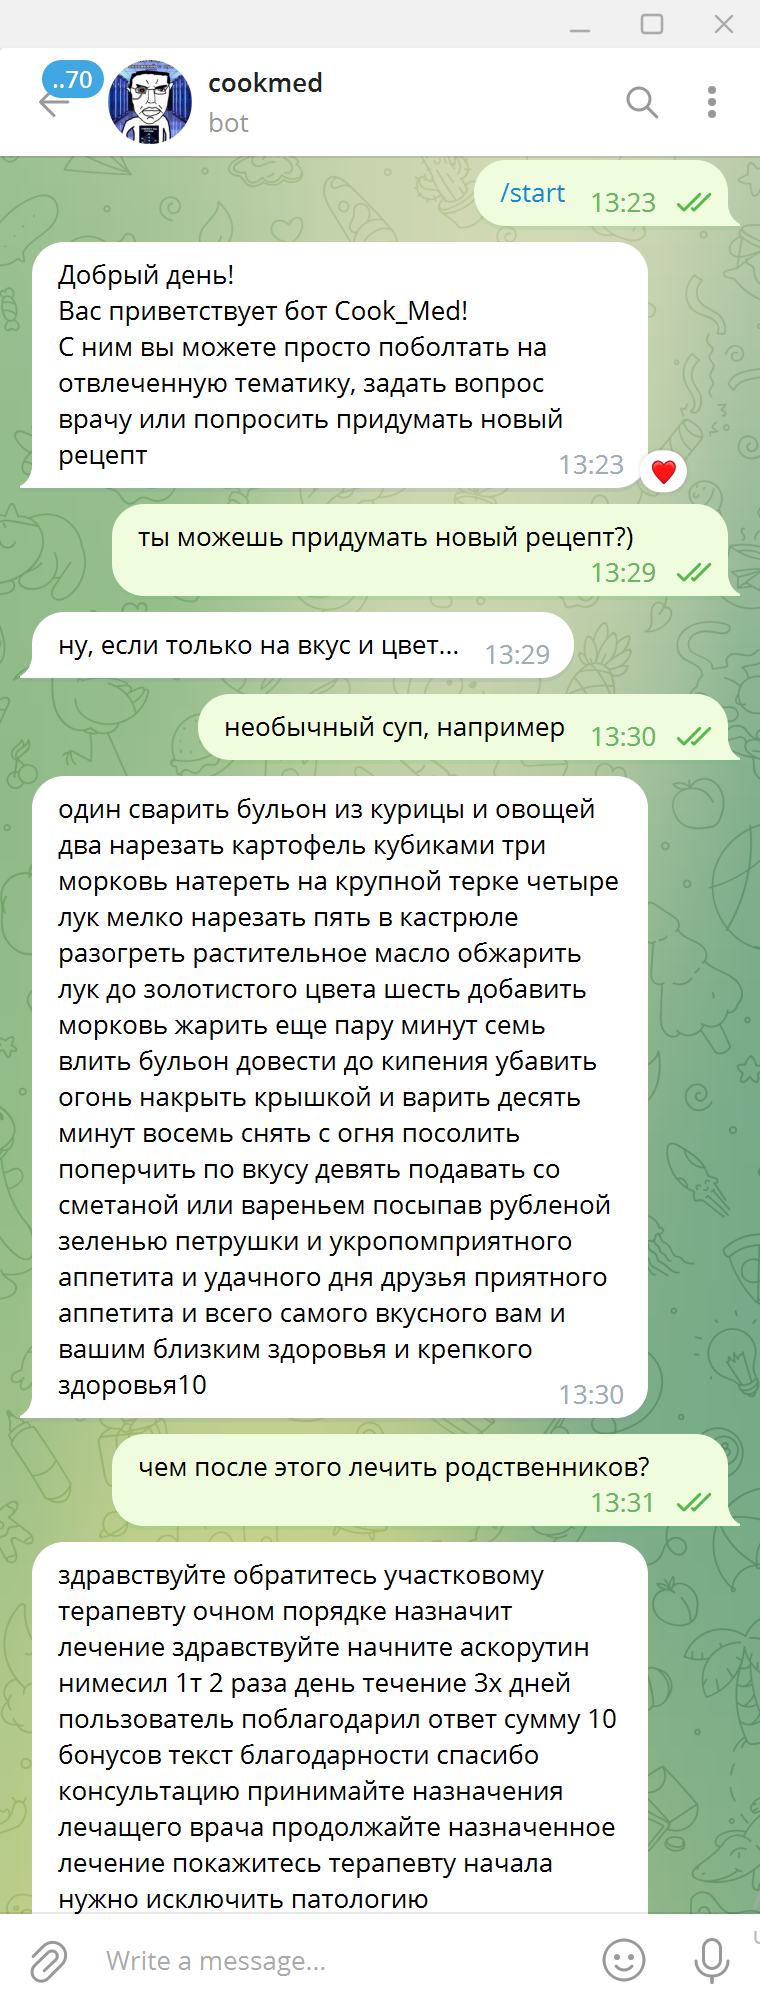